# Requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import os

# Loading Models

In [8]:
IMAGE_ADDRESS = os.path.join("images", "image1.jpg") 
YOLO_WEIGHT = os.path.join("models", "yolov3.weights") 
YOLO_CONFIG_PATH = os.path.join("models", "yolov3.cfg")
YOLO_LABELES_PATH = os.path.join("models", "coco.names") 
CONFIDENCE = 0.5
THRESHOLD = 0.3

print("Loading YOLO model from disk...")
if not os.path.exists(YOLO_CONFIG_PATH) or not os.path.exists(YOLO_WEIGHT):
    print("Error: YOLO config or weights file not found.")
    print(f"Config path: {YOLO_CONFIG_PATH} (Exists: {os.path.exists(YOLO_CONFIG_PATH)})")
    print(f"Weights path: {YOLO_WEIGHT} (Exists: {os.path.exists(YOLO_WEIGHT)})")
    net = None
else:
    try:
        net = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_PATH, YOLO_WEIGHT) # TODO
        if net.empty():
            print("Error: Failed to load YOLO model (network is empty). Files might be corrupted.")
            net = None
        else:
            print("YOLO model loaded successfully.")
    except cv2.error as e:
        print(f"OpenCV error loading YOLO model: {e}")
        net = None
    except Exception as e:
        print(f"An unexpected error occurred loading YOLO model: {e}")
        net = None

if not os.path.exists(YOLO_LABELES_PATH):
    print(f"Error: COCO labels file not found at {YOLO_LABELES_PATH}")
    LABELS = []
else:
    LABELS = open(YOLO_LABELES_PATH).read().strip().split("\n")


Loading YOLO model from disk...
YOLO model loaded successfully.


# Loading Image

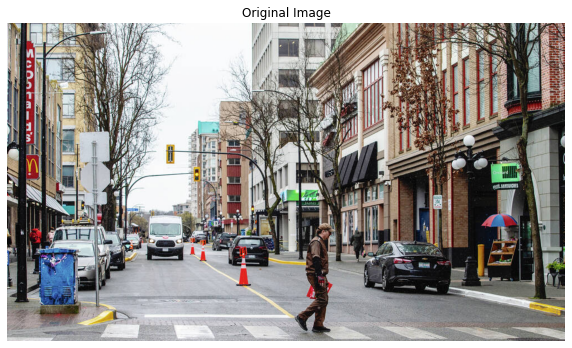

In [9]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")


image = cv2.imread(IMAGE_ADDRESS) 
if image is None:
    print(f"Error: Could not load image from {IMAGE_ADDRESS}")
    image = np.zeros((416, 416, 3), dtype="uint8")

(H, W) = image.shape[:2] 

# TODO
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
plt.title("Original Image")
plt.axis("off")
plt.show()




# Object Detection Function

In [10]:
def YOLO(input_image_bgr, network):
    if network is None:
        print("YOLO network not loaded. Skipping detection.")
        return input_image_bgr

    output_image = input_image_bgr.copy()
    (img_H, img_W) = output_image.shape[:2]

    all_layer_names = network.getLayerNames()
    unconnected_out_layers_output = network.getUnconnectedOutLayers()
    output_layer_names_final = [all_layer_names[int(i) - 1] for i in unconnected_out_layers_output.flatten()]
    ln = output_layer_names_final

    blob = cv2.dnn.blobFromImage(input_image_bgr, 1/255.0, (416, 416), swapRB=True, crop=False)
    network.setInput(blob)
    layerOutputs = network.forward(ln)

    boxes, confidences, classIDs = [], [], []
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > CONFIDENCE:
                box = detection[0:4] * np.array([img_W, img_H, img_W, img_H])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(output_image, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(output_image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return output_image


# Visualizing the Result

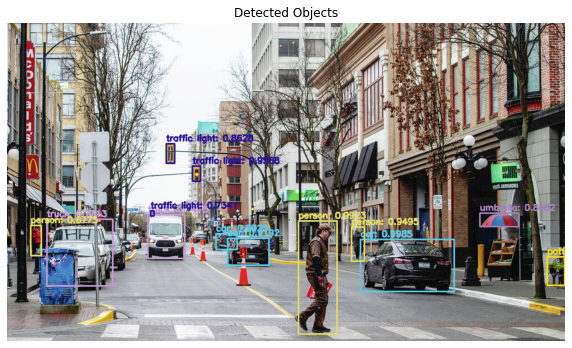


Script finished.


In [11]:
if net is not None and image is not None:
    result = YOLO(image.copy(), net) # TODO:
else:
    print("Skipping object detection as model or image is not loaded.")
    result = image 

if result is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)) 
    plt.title("Detected Objects")
    plt.axis("off")
    plt.show()

print("\nScript finished.")
